In [2]:
import json
import numpy as np

from argparse import ArgumentParser
from markethistory import MarketHistory
from backtest import Backtest
from constants import * 
from agent import Agent
from networks import *

%load_ext autoreload
%autoreload 2

def build_parser():
    parser = ArgumentParser()
    parser.add_argument('--mode',dest='mode',
                        help='start mode, train, generate, load_data'
                             ' backtest',
                        metavar='MODE', default='train')
    parser.add_argument('--net',dest='net',
                        help='conv, conv_fc'
                             ' backtest', default='conv')
    return parser

def get_data(config):
    data_global = MarketHistory(config).data
    num_feature, num_asset, T = data_global.shape
    btc_price_tensor = np.ones((num_feature, 1, T))
    data_global = np.concatenate((btc_price_tensor, data_global), axis=1)
    print('Global data tensor shape:', data_global.shape)
    return data_global

def main():
    with open('config.json') as file:
        config = json.load(file)
    parser = build_parser()
    options = parser.parse_args()

    if options.mode == 'train':
        print('Setting up agent and training model...')
        if options.net == 'conv':
            policy = DecisionNetwork_CNN()
        if options.net == 'conv_fc':
            policy = DecisionNetwork_FC()
        data_global = np.load('saves/data_global.npy')
        agent = Agent(policy, config, data=data_global)
        agent.train()
        torch.save(agent.policy, 'saves/agent.pt')
    elif options.mode == 'load_data':
        print('Loading global data...')
        data_global = get_data(config)
        np.save('saves/data_global.npy', data_global)
    elif options.mode == 'backtest':
        print('Preparing backtest on last trained model...')
        policy = torch.load('agent.pt')
        data_global = np.load('data_global.npy')
        agent = Agent(policy, config, data=data_global)
        bt = Backtest(agent, config)

In [3]:
with open('config.json') as file:
    config = json.load(file)

In [4]:
config

{'agent': {'batch_size': 256,
  'episodes': 1500,
  'gpu': True,
  'lr': 0.001,
  'num_assets': 12,
  'period': 1800,
  'sampling_bias': 0.0019,
  'txn_fee': 0.0025,
  'window': 50},
 'backtest': {'bt_end_date': '2018/04/20',
  'bt_start_date': '2018/04/10',
  'coins': ['BCH',
   'DASH',
   'DGB',
   'ETC',
   'ETH',
   'FCT',
   'GNT',
   'LTC',
   'SC',
   'STR',
   'XEM',
   'XMR',
   'XRP',
   'ZEC',
   'reversed_USDT'],
  'flat_fee': 0.0025,
  'include_fees': True,
  'period': 1800},
 'market_history': {'coins': ['BCH',
   'DASH',
   'DGB',
   'ETC',
   'ETH',
   'FCT',
   'GNT',
   'LTC',
   'SC',
   'STR',
   'XEM',
   'XMR',
   'XRP',
   'ZEC',
   'reversed_USDT'],
  'end_date': '2018/04/20',
  'features': ['close', 'high', 'low'],
  'ma_windows': [10, 200],
  'moving_average': True,
  'sampling_frequency': 300,
  'start_date': '2018/04/01',
  'std_window': 100}}

## Train

In [21]:
# policy = DecisionNetwork_CNN()
policy = DecisionNetwork_FC()

In [22]:
policy

DecisionNetwork_FC(
  (conv1): Conv2d(6, 6, kernel_size=[1, 6], stride=(1, 1))
  (conv2): Conv2d(6, 20, kernel_size=[1, 45], stride=(1, 1))
  (conv3): Conv2d(16, 1, kernel_size=[1, 1], stride=(1, 1))
  (linear1): Linear(in_features=21, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [23]:
data_global = np.load('saves/data_global.npy')
agent = Agent(policy, config, data=data_global)
agent.train()
torch.save(agent.policy, 'saves/agent.pt')

Checkpoint 0: Saving agent
episode 0  loss: 2.613737706269603e-07
episode 1  loss: -2.289534495503176e-05
episode 2  loss: -1.6785994375823066e-05
episode 3  loss: -4.2585063056321815e-05
episode 4  loss: -6.900591415615054e-06
episode 5  loss: -4.918152990285307e-05
episode 6  loss: -1.0417015801067464e-05
episode 7  loss: -2.4031718567130156e-05
episode 8  loss: -2.2506192181026563e-05
episode 9  loss: -2.406343446637038e-05


KeyboardInterrupt: 

In [24]:
saved_losses.append(agent.training_losses)

In [25]:
s = saved_losses[-1]
saved_losses = saved_losses[:-1]

In [26]:
saved_losses.extend(s)

In [27]:
len(saved_losses)

221

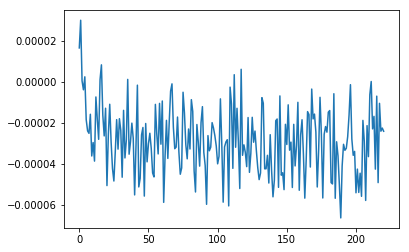

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(agent.training_losses)

## Backtest

In [7]:
print('Preparing backtest on last trained model...')
policy = torch.load('saves/agent.pt')
data_global = np.load('saves/data_global.npy')
agent = Agent(policy, config, data=data_global)
bt = Backtest(agent, config)

Preparing backtest on last trained model...
Getting backtest results for train data...
include_fees
Getting backtest results for test data...
include_fees
       Final portfolio value  Average return    Sharpe
Test               -0.027050    5.325249e-07 -3.057769
Train              -0.029575    7.131380e-49 -8.183120
Number of trades per asset: 
{'LTC': 476, 'GNT': 476, 'STR': 476, 'ETH': 476, 'BCH': 476, 'FCT': 476, 'XMR': 476, 'XEM': 476, 'ETC': 476, 'SC': 476, 'DASH': 476, 'DGB': 476}
